In [2]:
import torch
import random
import time
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import ast
import copy
import os
import pandas as pd
# from grid6_path_model_utils import * 

In [3]:
data = pd.read_csv('formal200-reachgoal.csv')

Actions_wstay = [(1,0), (-1,0), (0,1), (0,-1), (0,0)]
grid_size = 6
human_exp_actions = [(-1, 0), (1,0), (0,-1), (0,1)]
human_action_map = [1,0,3,2]

In [4]:
## belief inference 
%load_ext autoreload
%autoreload 2
from belief_inference_utils import *

In [5]:
human_model = torch.load('model_grid6.pt', map_location=torch.device('cpu'))


layouts = torch.zeros([4,30,4,6,6])

p = '../data/grid6/mturk_validation/'

for i, file in enumerate([
            'original_environments.pt',
            'our_approach_optimal_model.pt',
            'greed_true_data_driven.pt',
            'our_approach_data_driven.pt',
            ]):
    mapdata = torch.load(p + file , map_location=torch.device('cpu'))
    mapdata = torch.max(torch.zeros_like(mapdata), mapdata)
    layouts[i] = mapdata


In [6]:
row = data.iloc[0]
row
goal_id = row['goal']
actions = row['actions']
actions = [human_action_map[int(s)] for s in actions[1:-1].split(',')]
game = layouts[row['treatment'], row['gameidx2']]
actions

[2, 2, 2, 2]

In [7]:
n, goal_pos, block_pos, start_pos, spaces_pos = decode_grid_design(game, return_map = False)

human_prob = get_human_prob(human_model, 6, goal_pos, block_pos, start_pos, actions[:3])


In [8]:
human_prob


array([0.43018532, 0.56981468])

In [9]:
def generate_path(start_pos, actions):
    ## actions = moves, are current action; while path returns the passed positions
    Actions = [(1,0), (-1,0), (0,1), (0,-1)]
    ans = []
    tmp_pos = start_pos
    for a in actions:
        tmp_pos = (tmp_pos[0] + Actions[a][0], tmp_pos[1] + Actions[a][1],)
        ans.append(tmp_pos)
    return ans 

def get_distance_prob_shortest(goals, start_pos, layout, paths):
    ans = []
    for g in goals:
        dis = build_map(layout, start_pos = g)
        ans.append(dis[start_pos[0], start_pos[1]] - dis[paths[-1][0], paths[-1][1]]  ) ## start_point is always 0 
    return softmax(ans)

def build_map(layout, start_pos):
    dis = np.ones((6,6), dtype = int) * 100
    dis[start_pos[0], start_pos[1]] = 0
    blocked = layout[1].numpy().astype(int)
    Actions = [(1,0), (-1,0), (0,1), (0,-1)]
    distance = 0
    candidate_list = [start_pos]
    while len(candidate_list) >= 1 and distance <=20:  ## make sure no dead lock, and ignore rate cases where distance might be > 20
        for i, j in candidate_list:
            ## assign value 
            for a in Actions:
                m, n = i+a[0], j+a[1]
                if m>=0 and m<6 and n>=0 and n<6:
                    if blocked[m,n] == 0:
                        dis[m, n] = min (1+distance ,  dis[m, n])
        distance += 1
        candidate_list = list(np.argwhere(dis == distance))
        # print(len(candidate_list), distance)
    return dis

row = data.iloc[0]
row
goal_id = row['goal']
actions = row['actions']
actions = [human_action_map[int(s)] for s in actions[1:-1].split(',')]
game = layouts[row['treatment'], row['gameidx2']]
actions
n, goal_pos, block_pos, start_pos, spaces_pos = decode_grid_design(game, return_map = False)
path = generate_path(start_pos, actions)
dis_prob = get_distance_prob_shortest(goal_pos, start_pos, game, path)
dis_prob

array([0.5, 0.5])

In [10]:
path

[(5, 1), (5, 2), (5, 3), (5, 4)]

### WCD

In [11]:
data = pd.read_csv('formal200-reachgoal.csv')

Actions_wstay = [(1,0), (-1,0), (0,1), (0,-1), (0,0)]
grid_size = 6
human_exp_actions = [(-1, 0), (1,0), (0,-1), (0,1)]
human_action_map = [1,0,3,2]


layouts = torch.zeros([4,30,4,6,6])



for i, file in enumerate([
            'original_environments.pt',
            'our_approach_optimal_model.pt',
            'greed_true_data_driven.pt',
            'our_approach_data_driven.pt',
            ]):
    mapdata = torch.load(p + file , map_location=torch.device('cpu'))
    mapdata = torch.max(torch.zeros_like(mapdata), mapdata)
    layouts[i] = mapdata


In [12]:
data = data[data['reach_goal']>0]
print(data.shape)

(5999, 9)


In [13]:
data['move'] = data['actions'].apply(lambda x: [int(s) for s in x[1:-1].split(',')])
# actions = [human_action_map[int(s)] for s in actions[1:-1].split(',')]


In [14]:
def find_wcd(A:list, B:list):
    ans = np.zeros([len(A), len(B)])
    for i in range(len(A)):
        for j in range(len(B)):
            ans[i,j] = cal_start(A[i], B[j])    
    return ans 

def cal_start(a,b):
    c = 0
    for i in range(min(len(a), len(b))):
        if a[i] == b[i]:
            c += 1
        else:
            break
    return c



In [38]:
counts = np.zeros([4,30])
std = np.zeros([4,30])
mean10 = np.zeros([4,30, 21])
# std10 = np.zeros([4,30])
overlapping_actions = []
percentile_buckets_by_tmt = []
for treat in range(4):
    envs_o_actions = []
    env_per_buckets = []
    for gameidx in range(30):
        users = data[(data['treatment'] == treat) & (data['gameidx2']==gameidx)]
        A = users[users['goal']==0]
        B = users[users['goal']==1]
        # print(len(users), len(A), len(B))
        seq1 = list(A['move'])
        seq2 = list(B['move'])
        ans = find_wcd(seq1, seq2) # compute the ovrelap between different paths to different goals.
        counts[treat, gameidx] = np.mean(ans) # compute the mean overalap for the environment
        std[treat, gameidx] = np.std(ans)/np.sqrt(len(seq1)*len(seq2))
        for i,k in enumerate(range(0, 101, 5)):
            mean10[treat, gameidx, i] = np.percentile(ans, k)
        envs_o_actions.append([ans.mean(),ans.std()/np.sqrt(ans.size)])
        percentile_bucket = []
        
        for k in range(0,100,25):
            # Step 2: Determine the range [k, k+25]
            lower_bound = np.percentile(ans, k)
            upper_bound = np.percentile(ans, k+25)

            # Step 3: Filter the data to include only values within this range
            filtered_values = ans[(ans >= lower_bound) & (ans <= upper_bound)]
            print(k,lower_bound,upper_bound,filtered_values.shape[0])
            
            percentile_bucket.append([filtered_values.mean(),filtered_values.std()/np.sqrt(filtered_values.size)])
        env_per_buckets.append(percentile_bucket)
    percentile_buckets_by_tmt.append(env_per_buckets)
        
    overlapping_actions.append(envs_o_actions)
    print('finish ', treat)

0 0.0 0.0 430
25 0.0 0.0 430
50 0.0 1.0 492
75 1.0 5.0 220
0 0.0 0.0 280
25 0.0 1.0 499
50 1.0 1.0 219
75 1.0 6.0 350
0 5.0 5.0 648
25 5.0 5.0 648
50 5.0 5.0 648
75 5.0 5.0 648
0 0.0 4.0 293
25 4.0 5.0 413
50 5.0 5.0 262
75 5.0 6.0 357
0 0.0 4.0 572
25 4.0 4.0 485
50 4.0 4.0 485
75 4.0 5.0 551
0 0.0 4.0 509
25 4.0 4.0 459
50 4.0 4.0 459
75 4.0 5.0 594
0 4.0 4.0 650
25 4.0 4.0 650
50 4.0 4.0 650
75 4.0 4.0 650
0 0.0 3.0 650
25 3.0 3.0 500
50 3.0 3.0 500
75 3.0 3.0 500
0 0.0 0.0 445
25 0.0 0.0 445
50 0.0 1.0 511
75 1.0 9.0 193
0 1.0 1.0 184
25 1.0 4.0 366
50 4.0 6.0 336
75 6.0 8.0 263
0 0.0 4.0 550
25 4.0 4.0 525
50 4.0 4.0 525
75 4.0 5.0 625
0 2.0 3.0 487
25 3.0 3.0 460
50 3.0 3.0 460
75 3.0 7.0 621
0 0.0 0.0 208
25 0.0 3.0 650
50 3.0 3.0 390
75 3.0 3.0 390
0 1.0 3.0 648
25 3.0 3.0 540
50 3.0 3.0 540
75 3.0 3.0 540
0 0.0 0.0 328
25 0.0 0.0 328
50 0.0 1.0 497
75 1.0 5.0 316
0 1.0 3.0 650
25 3.0 3.0 525
50 3.0 3.0 525
75 3.0 3.0 525
0 0.0 4.0 644
25 4.0 4.0 520
50 4.0 4.0 520
75 4.0 4.0 5

In [16]:
means_stds = np.array(overlapping_actions)
means_stds =means_stds.mean(axis =1)
# means_stds.shape 
means_stds.mean(axis =1).shape

(4,)

In [47]:
from scipy.stats import ttest_ind

# Given treatments and overlapping actions
treatments = ["Original", "Proposed(opt-bhvr)", "Greedy", "Proposed(data-driven)"]
num_overlaps_by_treatment = np.array(overlapping_actions)[:,:,0]  # Assuming overlapping_actions is already defined

# Compute pairwise t-tests
p_values = {}
for i in range(len(treatments)):
    for j in range(i + 1, len(treatments)):
        t_stat, p_value = ttest_ind(num_overlaps_by_treatment[i, :], num_overlaps_by_treatment[j, :])
        p_values[f"{treatments[i]} vs. {treatments[j]}"] = p_value

# Print the p-values
for comparison, p_value in p_values.items():
    print(f"{comparison}: p-value = {p_value:.5f}")

Original vs. Proposed(opt-bhvr): p-value = 0.02081
Original vs. Greedy: p-value = 0.14021
Original vs. Proposed(data-driven): p-value = 0.00000
Proposed(opt-bhvr) vs. Greedy: p-value = 0.40171
Proposed(opt-bhvr) vs. Proposed(data-driven): p-value = 0.00106
Greedy vs. Proposed(data-driven): p-value = 0.00025


(4, 30)

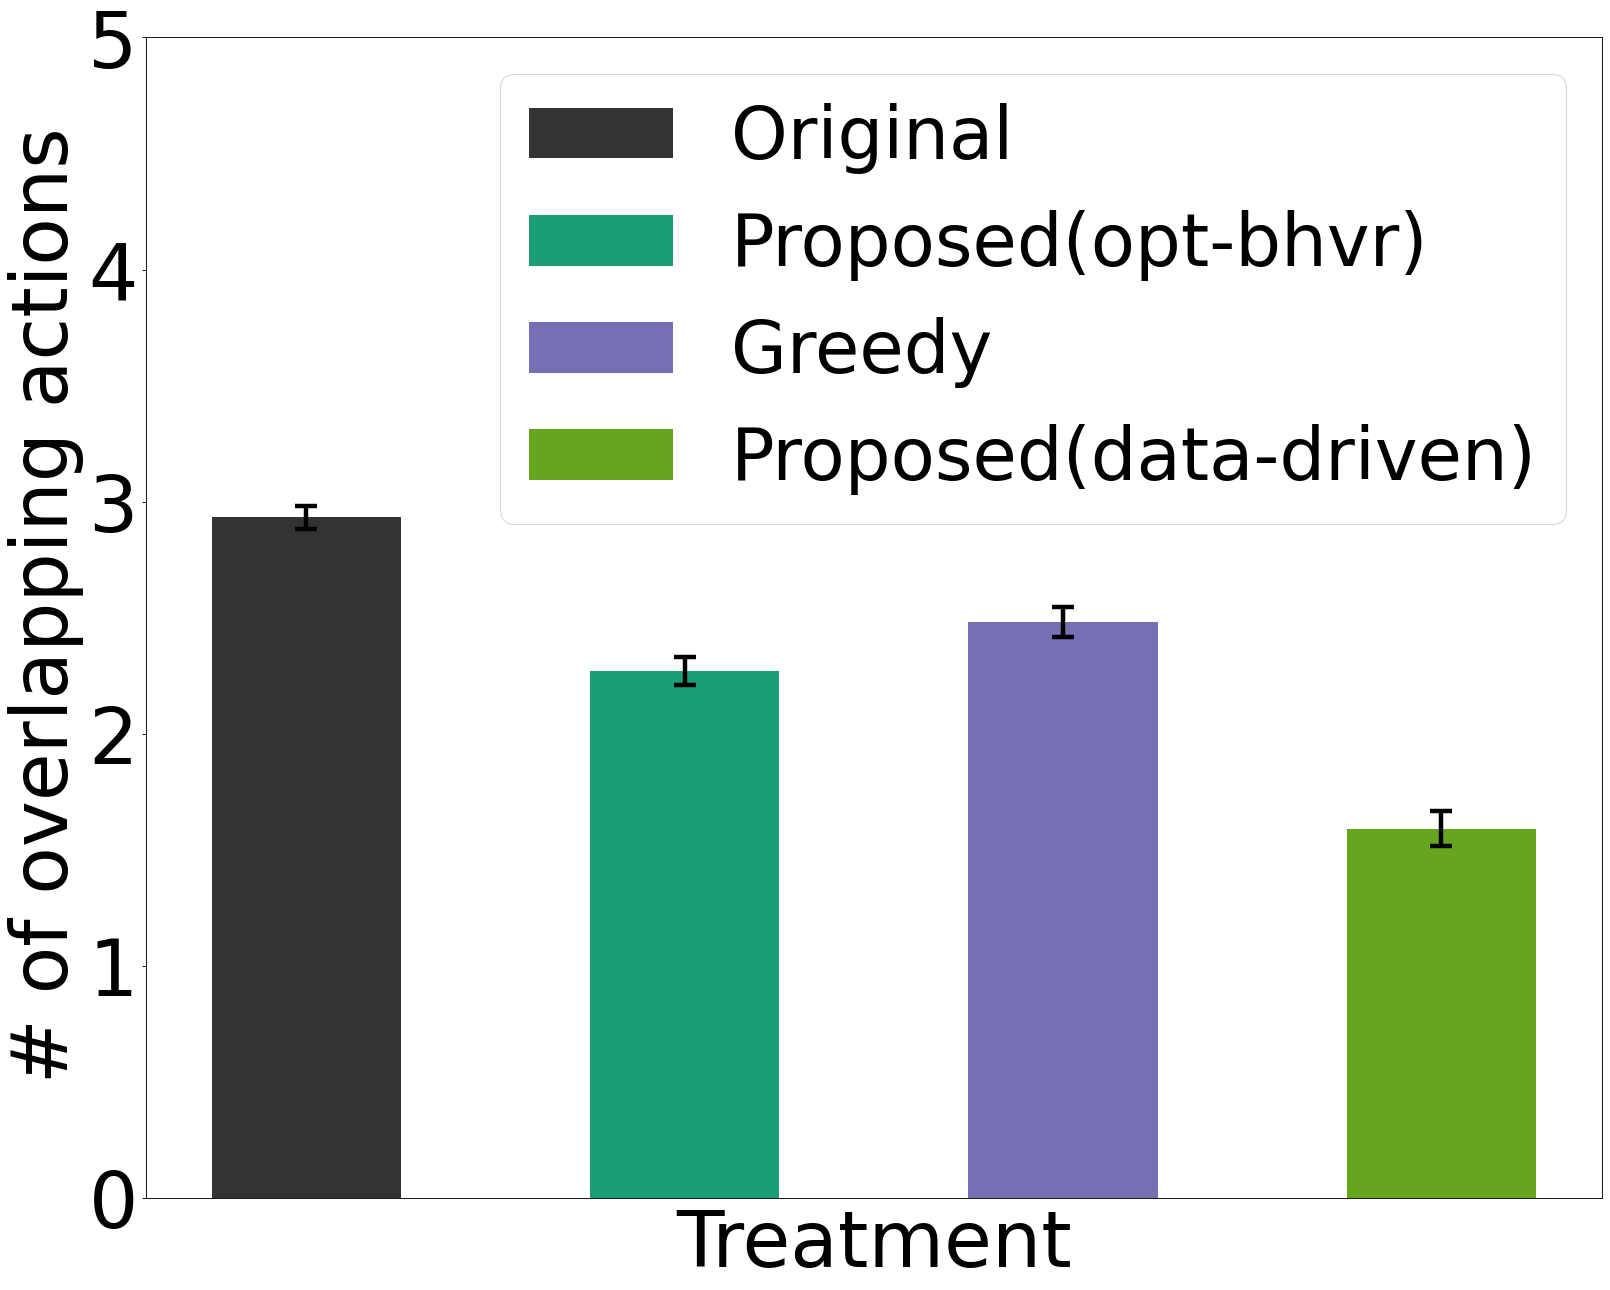

In [17]:
# Extract means and standard errors
means = means_stds[:, 0]
std_errors = means_stds[:, 1]

# Plot parameters
font_size = 70
bar_width = 0.5
positions = np.arange(len(means))


colors = ["#333333", "#1b9e77", "#7570b3", "#66a61e"]

fig, ax = plt.subplots(figsize=(20, 16), dpi=80, constrained_layout=True)

# Plotting bar plots with error bars
error_kw = {'elinewidth': 4, 'capsize': 10, 'capthick': 4}
bars = ax.bar(positions, means, yerr=std_errors, width=bar_width, color=colors, error_kw=error_kw)

# Setting the x-axis labels
ax.set_xticks([])
# ax.set_xticklabels(treatments)

ax.set_xlabel('Treatment')
ax.set_ylabel(' # of overlapping actions')
ax.set_ylim(0,5)
# ax.set_ylim([0, max(means + std_errors) + 1])

ax.legend(bars, treatments, fontsize=font_size - 5)

# Set font size for various elements
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
plt.savefig('plots/bar_mean_human_non_distinctiveness.pdf',format="pdf", bbox_inches="tight",dpi=500)

In [18]:
percentile_means=np.array(percentile_buckets_by_tmt).mean(axis =1)
percentile_means.shape

(4, 4, 2)

In [28]:
np.array(percentile_buckets_by_tmt)[0].shape

(30, 4, 2)

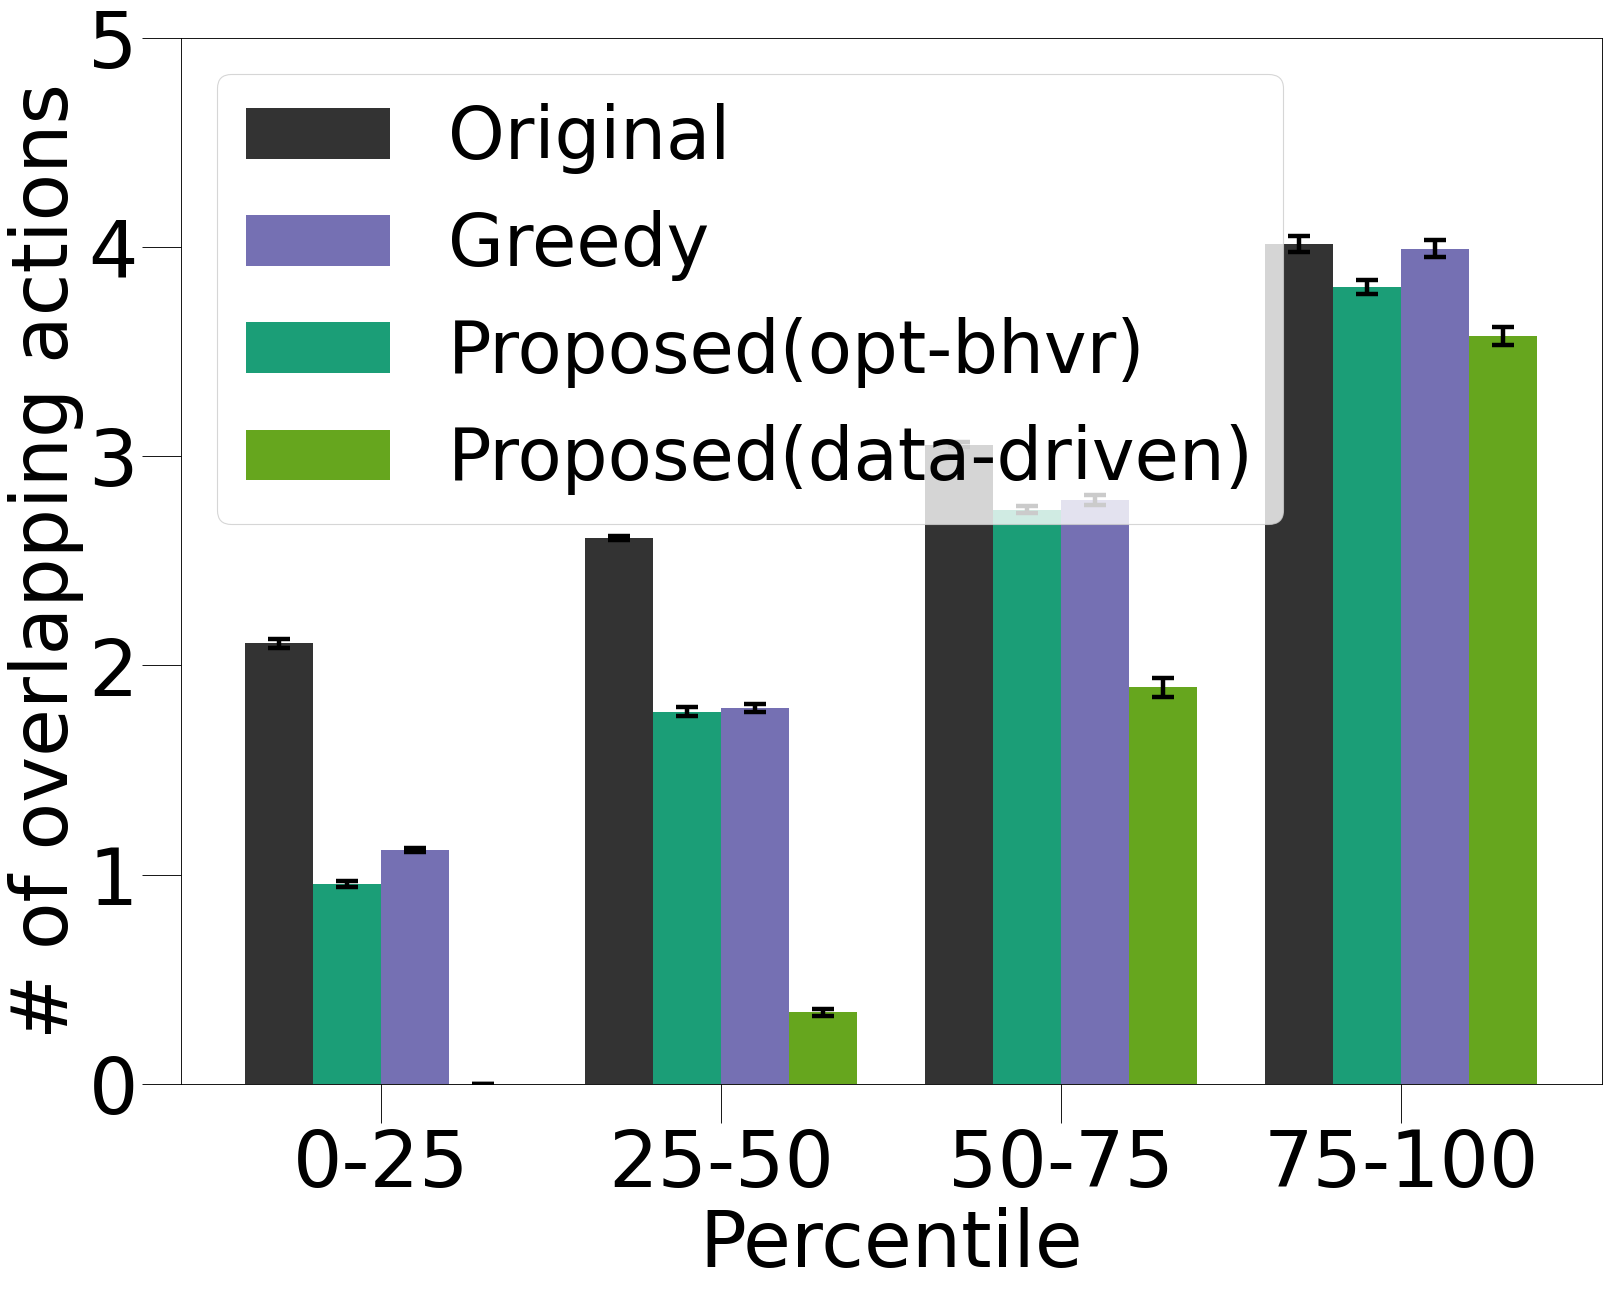

In [20]:


# Extract the mean and standard deviation for the desired percentiles

y = percentile_means[:,:,0]
ystd = percentile_means[:,:,1]

# Plot parameters
font_size = 70
bar_width = 0.2
positions = np.arange(percentile_means.shape[1])



fig, ax = plt.subplots(figsize=(20, 16), dpi=80, constrained_layout=True)
error_kw = {'elinewidth': 4, 'capsize': 10, 'capthick': 4}
# Plotting bar plots
for i in range(4):
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, y[i],yerr=ystd[i], width=bar_width, label=treatments[i], color=colors[i], capsize=5,error_kw=error_kw)
    #yerr=ystd[i]

# Setting the x-axis labels
ax.set_xticks(positions + 1.5 * bar_width)
ax.set_xticklabels(["0-25","25-50","50-75","75-100"])

ax.set_xlabel('Percentile')
ax.set_ylabel('# of overlapping actions')
ax.set_ylim([0, 5])

ax.legend(fontsize=font_size - 5)

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Define the desired order
desired_order = [0,2,1,3]  # New order: Orginal, Greedy, Prop(opt-bhvr) and Prop (data-driven)

# Reorder handles and labels
handles = [handles[i] for i in desired_order]
labels = [labels[i] for i in desired_order]

ax.legend(handles, labels, fontsize=font_size - 5)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
ax.tick_params(axis='both', which='major', length=font_size/2)
plt.savefig('plots/percentile_overlapping_actions.pdf',format="pdf", bbox_inches="tight",dpi=500)

In [21]:
np.percentile(ans, 10),np.percentile(ans, 100)

(0.0, 6.0)

In [22]:
print(np.mean(counts, axis=1))

([
            'original_environments.pt',
            'our_approach_optimal_model.pt',
            'greed_true_data_driven.pt',
            'our_approach_data_driven.pt',
            ])

[2.93221648 2.2695032  2.48098244 1.590151  ]


['original_environments.pt',
 'our_approach_optimal_model.pt',
 'greed_true_data_driven.pt',
 'our_approach_data_driven.pt']

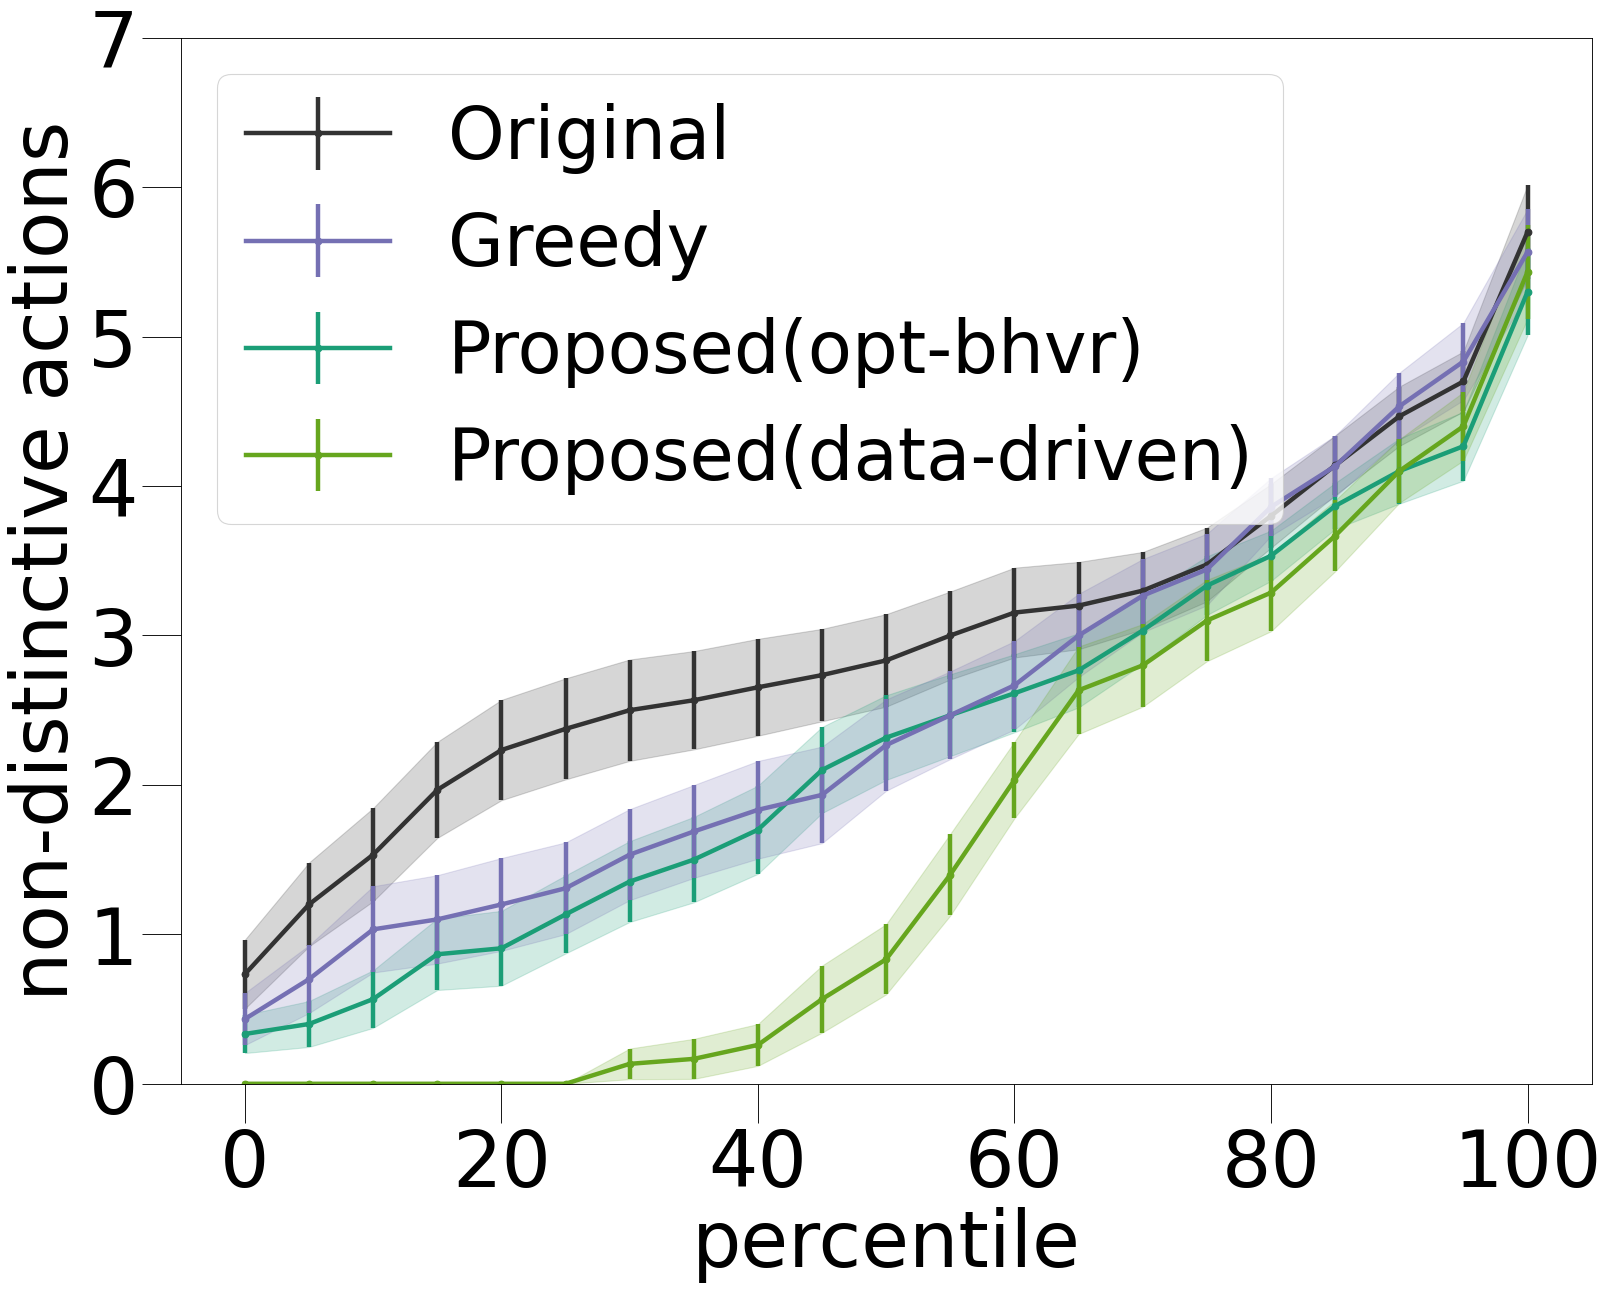

In [23]:
y = np.mean(mean10, axis=1)
ystd = np.std(mean10, axis=1)/np.sqrt(30)
font_size =70

fig, ax = plt.subplots(figsize=(20, 16), dpi=80, constrained_layout=True)
lw=8
x = np.arange(0,101,5)

colors = ["#333333","#1b9e77","#7570b3","#66a61e"]

for i in range(4):
    ax.errorbar(x, y[i], yerr=ystd[i], fmt='o-', label =treatments[i], color =colors[i], linewidth = 4 )
    ax.fill_between(x, y[i] - ystd[i],
                                 y[i] + ystd[i], alpha=0.2,
                                 color=colors[i])
ax.set_xlabel('percentile')
ax.set_ylabel("non-distinctive actions")
ax.set_ylim([0, 7])

ax.legend(fontsize=font_size - 5)

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Define the desired order
desired_order = [0,2,1,3]  # New order: Orginal, Greedy, Prop(opt-bhvr) and Prop (data-driven)

# Reorder handles and labels
handles = [handles[i] for i in desired_order]
labels = [labels[i] for i in desired_order]

ax.legend(handles, labels, fontsize=font_size - 5)
# ax.grid()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
ax.tick_params(axis='both', which='major', length=font_size/2)
plt.savefig('plots/human_non_distinctiveness.pdf',format="pdf", bbox_inches="tight",dpi=500)
plt.show()

In [24]:
mean10.shape

(4, 30, 21)

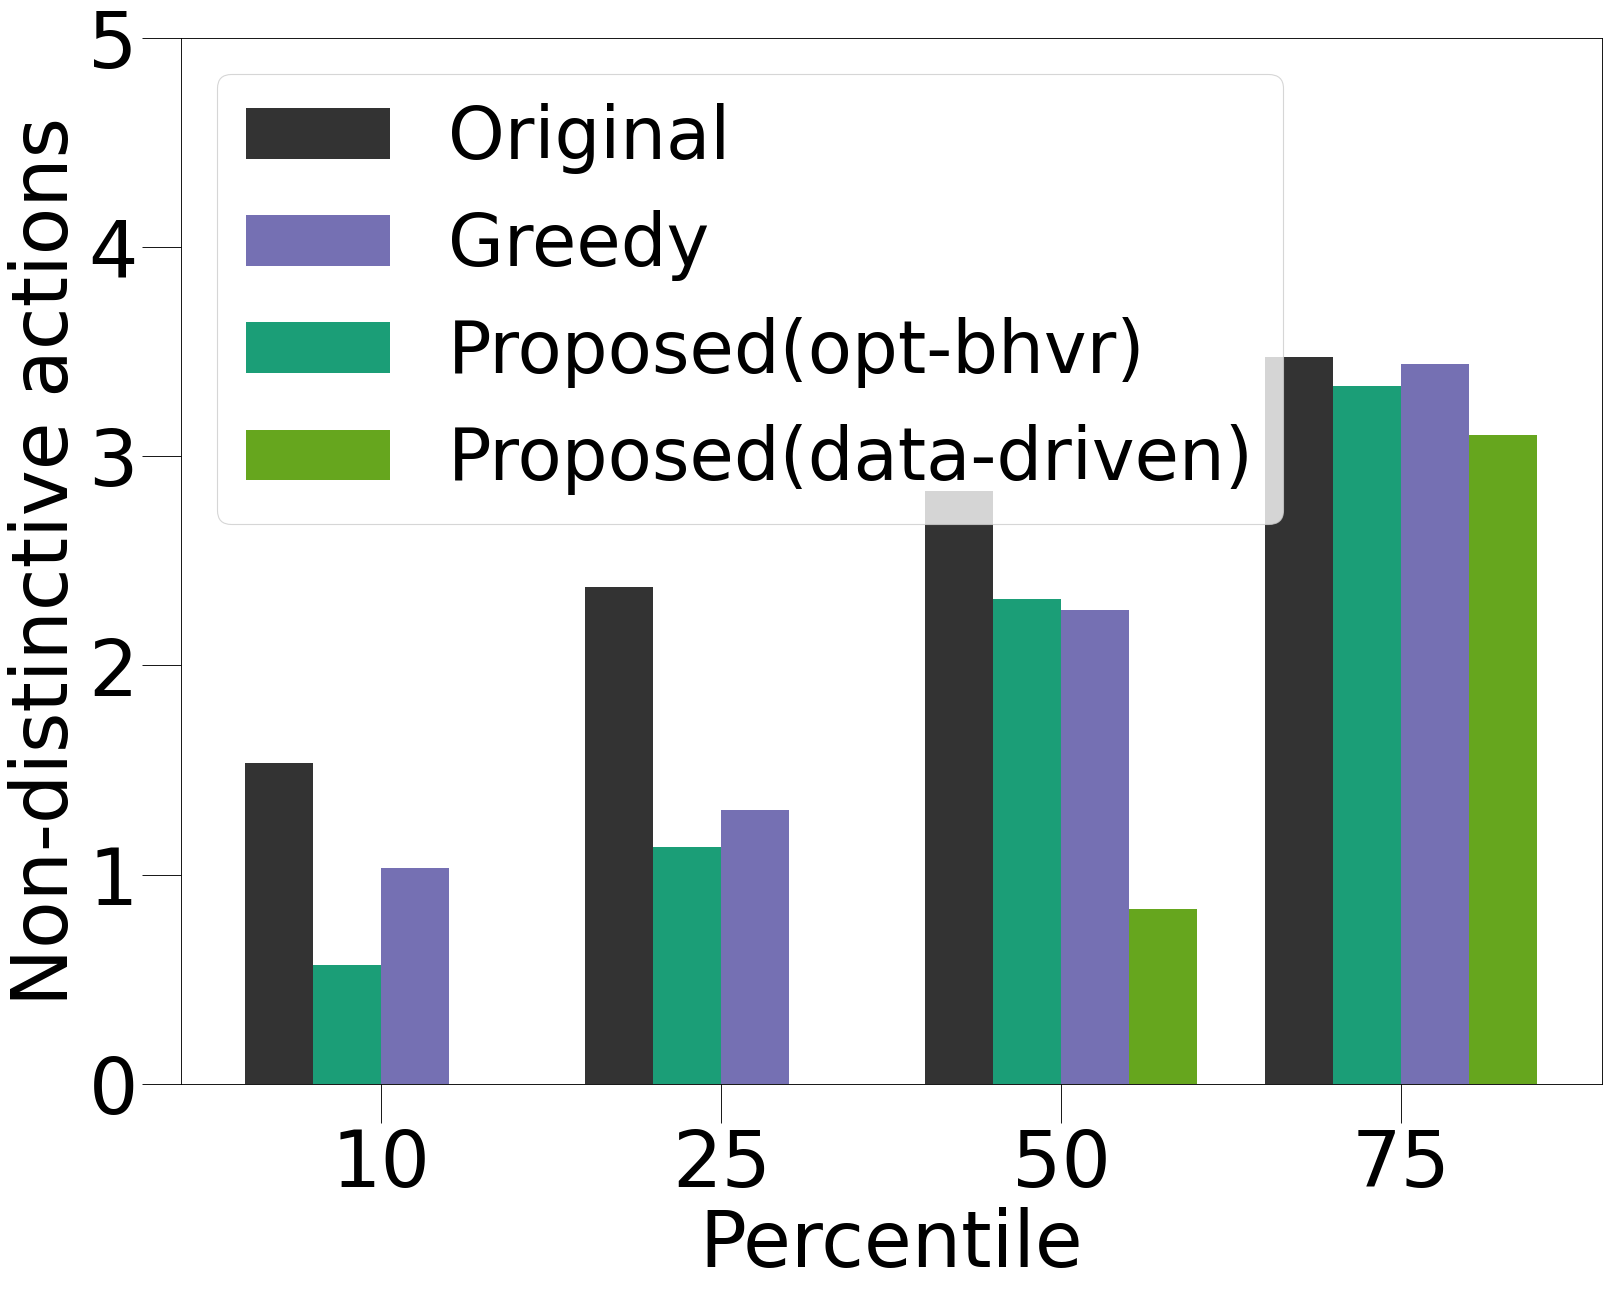

In [25]:
# Define the desired percentiles
desired_percentiles = [10, 25, 50, 75]

# Create an array representing all percentiles (0, 10, 20, ..., 100)
all_percentiles = np.arange(0, 101, 5)

# Assuming mean10 is your data matrix, where rows correspond to different conditions
# and columns to different percentiles

# Extract the mean and standard deviation for the desired percentiles
indices = [all_percentiles.tolist().index(p) for p in desired_percentiles]
y = np.mean(mean10, axis=1)[:, indices]
ystd = (np.std(mean10, axis=1)/np.sqrt(30*400))[:, indices]

# Plot parameters
font_size = 70
bar_width = 0.2
positions = np.arange(len(desired_percentiles))



fig, ax = plt.subplots(figsize=(20, 16), dpi=80, constrained_layout=True)

# Plotting bar plots
for i in range(4):
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, y[i], width=bar_width, label=treatments[i], color=colors[i], capsize=5)
    #yerr=ystd[i]

# Setting the x-axis labels
ax.set_xticks(positions + 1.5 * bar_width)
ax.set_xticklabels(desired_percentiles)

ax.set_xlabel('Percentile')
ax.set_ylabel('Non-distinctive actions')
ax.set_ylim([0, 5])

ax.legend(fontsize=font_size - 5)

# Extract handles and labels
handles, labels = ax.get_legend_handles_labels()

# Define the desired order
desired_order = [0,2,1,3]  # New order: Orginal, Greedy, Prop(opt-bhvr) and Prop (data-driven)

# Reorder handles and labels
handles = [handles[i] for i in desired_order]
labels = [labels[i] for i in desired_order]

ax.legend(handles, labels, fontsize=font_size - 5)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
ax.tick_params(axis='both', which='major', length=font_size/2)
plt.savefig('plots/bar_percentile_human_non_distinctiveness.pdf',format="pdf", bbox_inches="tight",dpi=500)

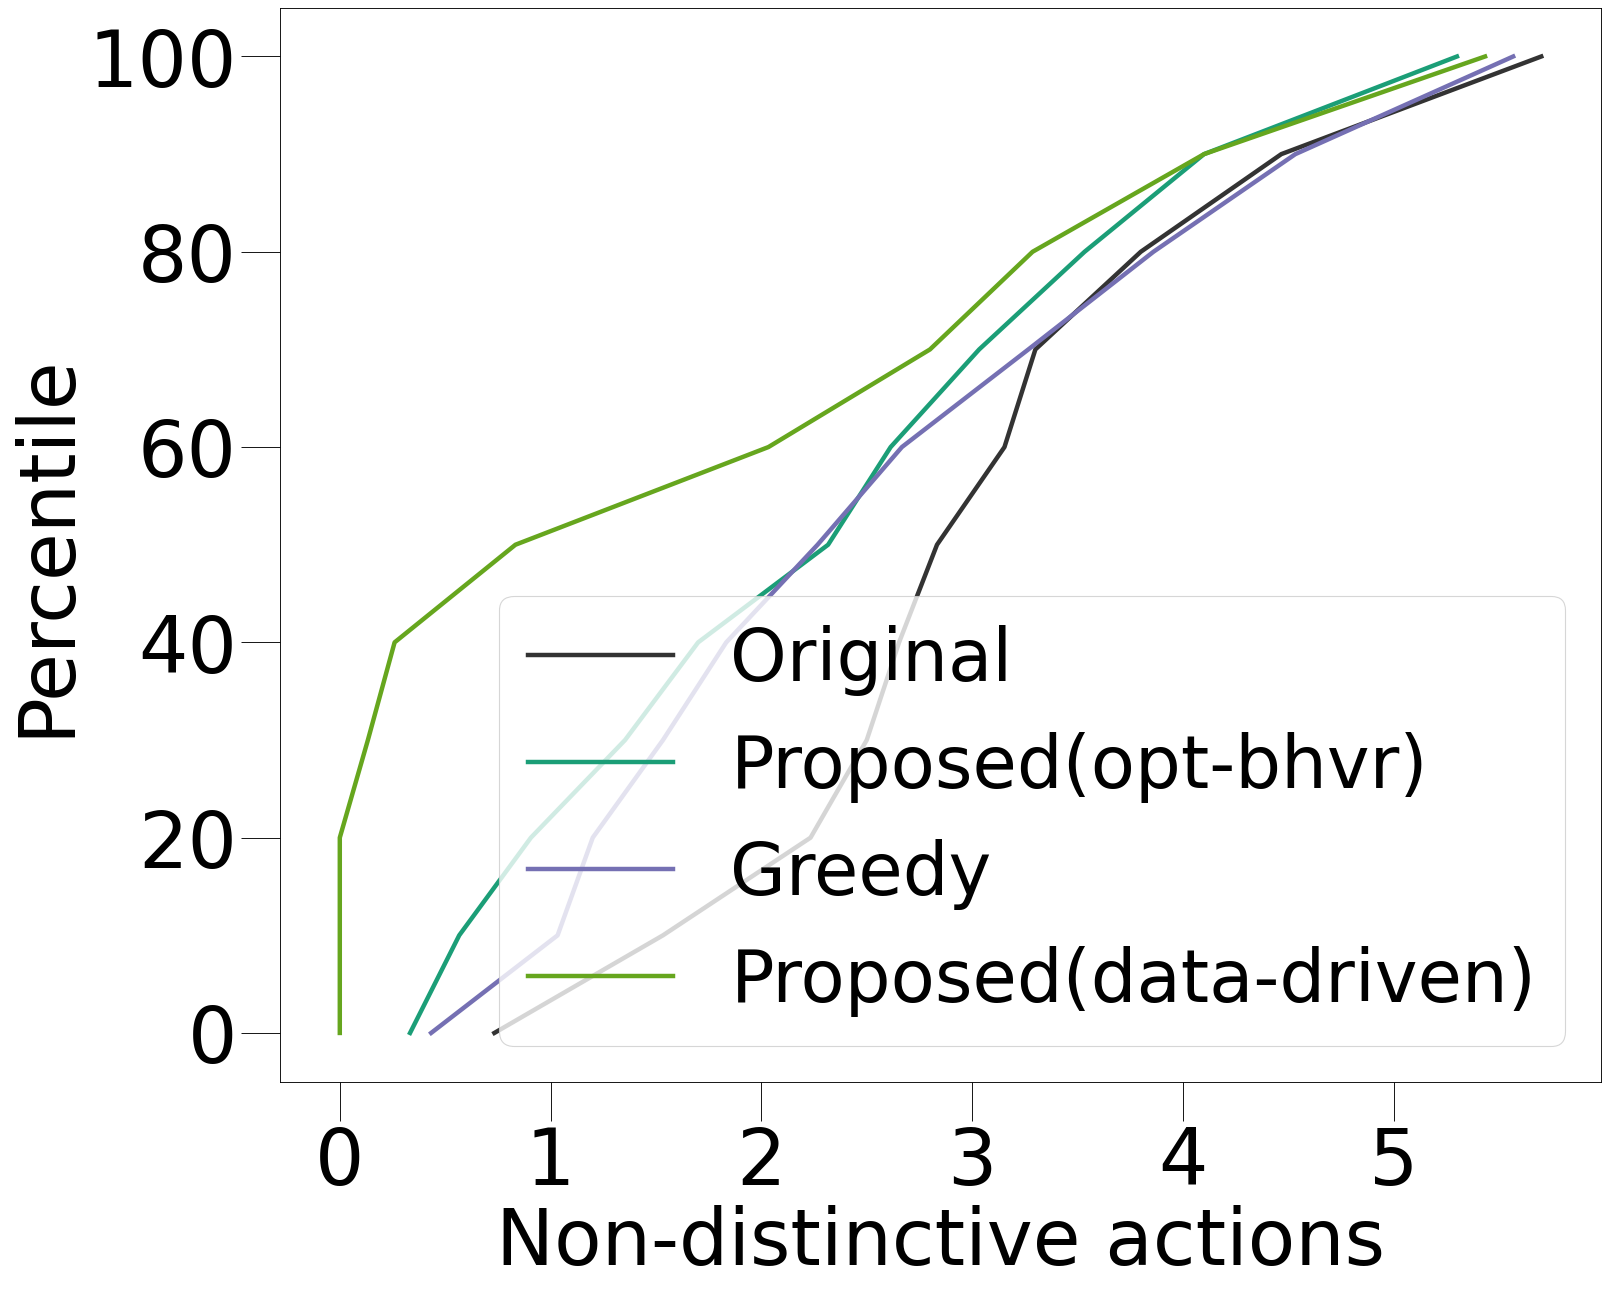

In [26]:

desired_percentiles = np.arange(0, 101, 10)
# Create an array representing all percentiles (0, 10, 20, ..., 100)
all_percentiles = np.arange(0, 101, 5)
x = np.array(desired_percentiles)


# Extract the mean for the desired percentiles
indices = [all_percentiles.tolist().index(p) for p in desired_percentiles]
y = np.mean(mean10, axis=1)[:,indices]

# Plot parameters
font_size = 70
line_width = 4


fig, ax = plt.subplots(figsize=(20, 16), dpi=80, constrained_layout=True)

# Plotting CDFs
for i in range(4):
    ax.plot(y[i],x, label=treatments[i], color=colors[i], linewidth=line_width)

ax.set_xlabel('Non-distinctive actions')
ax.set_ylabel('Percentile')
# ax.set_ylim([0, np.max(y) + 1])

ax.legend(fontsize=font_size - 5)

# Set font size for various elements
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(font_size)
ax.tick_params(axis='both', which='major', length=font_size / 2)